# MACHINE LEARNING EN TRADING, MODELO DE CLASIFICACIÓN
## CASO: APPL

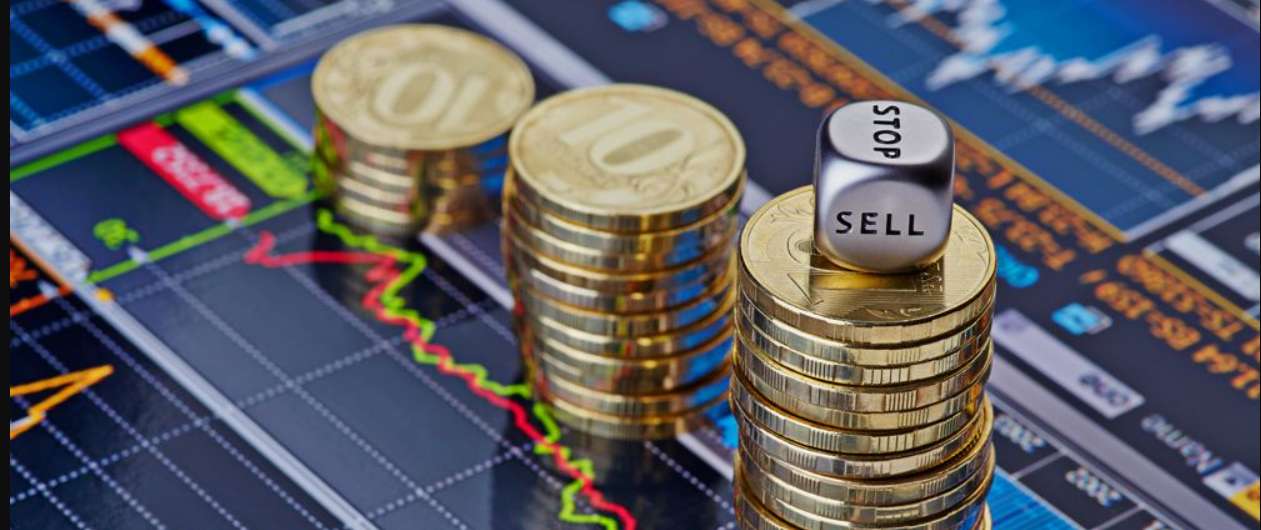

In [64]:
#!pip install yfinance --upgrade
#!pip install ta
#!pip install backtesting
#!pip install --upgrade plotly==5.20.0
#!pip install mplfinance
#!pip install pandas_ta==0.3.14b0
#!pip install numpy==1.24.3
#!pip install catboost # Install catboost
#!pip install quantstats

In [65]:
import yfinance as yf
import ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import plotly.graph_objects as go
import mplfinance as mpf
import pandas_ta as pdta
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
#
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'
#
import quantstats as qs

# Machine Learning

In [66]:
# Machine Learning
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Modelos
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


# Eliminamos advertencias
import warnings
warnings.filterwarnings("ignore")

#Importamos los datos de AAPL

In [67]:
# Descargar datos
aapl = yf.download('AAPL', auto_adjust=False, end='2025-05-14').dropna()
aapl.columns = aapl.columns.droplevel(1)
aapl

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1980-12-12,0.098597,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.093453,0.121652,0.122210,0.121652,0.122210,175884800
1980-12-16,0.086594,0.112723,0.113281,0.112723,0.113281,105728000
1980-12-17,0.088737,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-18,0.091310,0.118862,0.119420,0.118862,0.118862,73449600
...,...,...,...,...,...,...
2025-05-07,195.992981,196.250000,199.440002,193.250000,199.169998,68536700
2025-05-08,197.231369,197.490005,200.050003,194.679993,197.720001,50478900
2025-05-09,198.270004,198.529999,200.539993,197.539993,199.000000,36453900


In [68]:
# Gráfico con subplots
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    row_heights=[0.70,0.30], subplot_titles=("Precio AAPL ","Volumen")
)

# Velas japonesas
fig.add_trace(go.Candlestick(
    x=aapl.index,
    open=aapl['Open'],
    high=aapl['High'],
    low=aapl['Low'],
    close=aapl['Adj Close'],
    name='Velas',
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)

# Volumen
fig.add_trace(go.Bar(
    x=aapl.index,
    y=aapl['Volume'],
    name='Volumen',
    marker_color='red',
    opacity=0.5
), row=2, col=1)

# Layout final
fig.update_layout(
    title='AAPL - Precio Histórico Ajustado ',
    xaxis_rangeslider_visible=False,
    height=700,
    template='ggplot2'
)

fig.add_annotation(text='Apple (AAPL)',
                    font=dict(color='white', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)
fig.show()


In [69]:
len(aapl)

11195

# Conjuntos de Entrenamiento y Test

In [70]:
# Separación de los datos
train = aapl[aapl.index.year <= 2014]
test = aapl[aapl.index.year >= 2015]

# Agregamos Lagg y Retorno Diario

In [71]:
# Lagg o  Close_Shift
train['Close_Shift'] = train['Adj Close'].shift(1)
test['Close_Shift'] = test['Adj Close'].shift(1)

# Agregamos Variable Retorno Diario
train['Return'] = (train['Adj Close']/train['Close_Shift'] - 1) * 100
test['Return'] = (test['Adj Close']/test['Close_Shift'] - 1) * 100

## Train

In [72]:
train

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return
Date,,,,,,,,
1980-12-12,0.098597,0.128348,0.128906,0.128348,0.128348,469033600,NaN,NaN
1980-12-15,0.093453,0.121652,0.122210,0.121652,0.122210,175884800,0.098597,-5.217065
1980-12-16,0.086594,0.112723,0.113281,0.112723,0.113281,105728000,0.093453,-7.339794
1980-12-17,0.088737,0.115513,0.116071,0.115513,0.115513,86441600,0.086594,2.475033
1980-12-18,0.091310,0.118862,0.119420,0.118862,0.118862,73449600,0.088737,2.899291
...,...,...,...,...,...,...,...,...
2014-12-24,24.883966,28.002501,28.177500,28.002501,28.145000,57918400,25.001705,-0.470923
2014-12-26,25.323847,28.497499,28.629999,28.002501,28.025000,134884000,24.883966,1.767726
2014-12-29,25.306065,28.477501,28.692499,28.424999,28.447500,110395600,25.323847,-0.070219


# Test

In [73]:
test

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return
Date,,,,,,,,
2015-01-02,24.288574,27.332500,27.860001,26.837500,27.847500,212818400,NaN,NaN
2015-01-05,23.604334,26.562500,27.162500,26.352501,27.072500,257142000,24.288574,-2.817128
2015-01-06,23.606552,26.565001,26.857500,26.157499,26.635000,263188400,23.604334,0.009398
2015-01-07,23.937563,26.937500,27.049999,26.674999,26.799999,160423600,23.606552,1.402199
2015-01-08,24.857304,27.972500,28.037500,27.174999,27.307501,237458000,23.937563,3.842249
...,...,...,...,...,...,...,...,...
2025-05-07,195.992981,196.250000,199.440002,193.250000,199.169998,68536700,198.250015,-1.138479
2025-05-08,197.231369,197.490005,200.050003,194.679993,197.720001,50478900,195.992981,0.631853
2025-05-09,198.270004,198.529999,200.539993,197.539993,199.000000,36453900,197.231369,0.526608


# Variables Objetivo

In [74]:
# Creamos variables Objetivo en cada conjunto, Test y Train
train['target'] = np.where(train['Return'].shift(-1) > 0, 1, 0)
test['target'] = np.where(test['Return'].shift(-1) > 0, 1, 0)

In [75]:
train.head(20)

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,target
Date,,,,,,,,,
1980-12-12,0.098597,0.128348,0.128906,0.128348,0.128348,469033600,NaN,NaN,0
1980-12-15,0.093453,0.121652,0.122210,0.121652,0.122210,175884800,0.098597,-5.217065,0
1980-12-16,0.086594,0.112723,0.113281,0.112723,0.113281,105728000,0.093453,-7.339794,1
1980-12-17,0.088737,0.115513,0.116071,0.115513,0.115513,86441600,0.086594,2.475033,1
1980-12-18,0.091310,0.118862,0.119420,0.118862,0.118862,73449600,0.088737,2.899291,1
1980-12-19,0.096882,0.126116,0.126674,0.126116,0.126116,48630400,0.091310,6.102834,1
1980-12-22,0.101597,0.132254,0.132813,0.132254,0.132254,37363200,0.096882,4.867019,1
1980-12-23,0.105884,0.137835,0.138393,0.137835,0.137835,46950400,0.101597,4.219842,1
1980-12-24,0.111457,0.145089,0.145647,0.145089,0.145089,48003200,0.105884,5.262795,1


In [76]:
test.tail(20)

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,target
Date,,,,,,,,,
2025-04-15,201.875275,202.139999,203.509995,199.800003,201.860001,51343900,202.254776,-0.187635,0
2025-04-16,194.015579,194.270004,200.699997,192.369995,198.360001,59732400,201.875275,-3.893342,1
2025-04-17,196.722031,196.979996,198.830002,194.419998,197.199997,51334300,194.015579,1.394966,0
2025-04-21,192.907028,193.160004,193.800003,189.809998,193.270004,46742500,196.722031,-1.939286,1
2025-04-22,199.478424,199.740005,201.589996,195.970001,196.119995,52976400,192.907028,3.406509,1
2025-04-23,204.332062,204.600006,208.000000,202.800003,206.000000,52929200,199.478424,2.433164,1
2025-04-24,208.097107,208.369995,208.830002,202.940002,204.889999,47311000,204.332062,1.842611,1
2025-04-25,209.005920,209.279999,209.750000,206.199997,206.369995,38222300,208.097107,0.436726,1
2025-04-28,209.864792,210.139999,211.500000,207.460007,210.000000,38743100,209.005920,0.410932,1




#Ahora podemos dividir nuestros dataset en:
Características $(X)$ y
Variable Target $(Y)$

In [77]:
X_train = train.drop('target', axis = 1) # Seleccionamos Variables Predictoras
y_train = train.target # Seleccionamos Variable Target
###
X_test = test.drop('target', axis = 1) # Variables Predictoras
y_test = test.target # Variable Target

In [78]:
X_test

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return
Date,,,,,,,,
2015-01-02,24.288574,27.332500,27.860001,26.837500,27.847500,212818400,NaN,NaN
2015-01-05,23.604334,26.562500,27.162500,26.352501,27.072500,257142000,24.288574,-2.817128
2015-01-06,23.606552,26.565001,26.857500,26.157499,26.635000,263188400,23.604334,0.009398
2015-01-07,23.937563,26.937500,27.049999,26.674999,26.799999,160423600,23.606552,1.402199
2015-01-08,24.857304,27.972500,28.037500,27.174999,27.307501,237458000,23.937563,3.842249
...,...,...,...,...,...,...,...,...
2025-05-07,195.992981,196.250000,199.440002,193.250000,199.169998,68536700,198.250015,-1.138479
2025-05-08,197.231369,197.490005,200.050003,194.679993,197.720001,50478900,195.992981,0.631853
2025-05-09,198.270004,198.529999,200.539993,197.539993,199.000000,36453900,197.231369,0.526608



Para incrementar la habilidad predictora del modelo, debemos eincrementar la cantidad de variables predictoras para que el modelo sea más robusto y haga mejor su trabajo

la función feature_engineering() agrega algunos indicadores que incrementaran el nivel de variables independientes, de ellas el modelo aprenderá e identificará patrones para calcular las probabilidades de los valoresde las variables target

Usaremos lo más común en Analisis Técnico

In [79]:
# Función de Ingeniería de Características
def feature_engineering(df):

    # Medias Móviles Simples
    df['sma5'] = ta.trend.sma_indicator(df['Adj Close'],window = 5)
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'],window = 10)
    df['sma15'] = ta.trend.sma_indicator(df['Adj Close'],window = 15)
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'],window = 20)
    df['sma30'] = ta.trend.sma_indicator(df['Adj Close'],window = 30)
    df['sma50'] = ta.trend.sma_indicator(df['Adj Close'],window = 50)
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'],window = 80)
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'],window = 100)
    df['sma200'] = ta.trend.sma_indicator(df['Adj Close'],window = 200)

    # Agregamos Precios a los Ratios de Medias Moviles

    df['sma5_ratio'] = df['Adj Close'] / df['sma5']
    df['sma10_ratio'] = df['Adj Close'] / df['sma10']
    df['sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['sma30_ratio'] = df['Adj Close'] / df['sma30']
    df['sma50_ratio'] = df['Adj Close'] / df['sma50']
    df['sma80_ratio'] = df['Adj Close'] / df['sma80']
    df['sma100_ratio'] = df['Adj Close'] / df['sma100']
    df['sma200_ratio'] = df['Adj Close'] / df['sma200']

    # RSI, CCI, Bollinger Bands, y OBV

    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Adj Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()

    # Agregamos características derivadas de los indicadores de arriba

    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['above_bb_high'] = (df['Adj Close'] >= df['bb_high']).astype(int)
    df['below_bb_low'] = (df['Adj Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close'].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close'].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int)
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int)
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int)
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int)
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int)
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int)
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)

    # Quitamos NaN
    df.dropna(inplace = True)
    return df

#Usando la funcion de Ingeniería de Características en X

In [80]:
# Aplicamos en X
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [81]:
X_train.head()

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,cci_high,cci_low,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200
Date,,,,,,,,,,,,,,,,,,,,,
1981-09-28,0.049298,0.064174,0.064732,0.064174,0.064174,91728000,0.048870,0.877153,0.053757,0.057701,...,0,1,0,0,0,0,0,0,0,0
1981-09-29,0.051870,0.067522,0.068080,0.067522,0.067522,94684800,0.049298,5.217057,0.052556,0.056543,...,0,0,0,0,0,0,0,0,0,0
1981-09-30,0.052299,0.068080,0.068638,0.068080,0.068080,49996800,0.051870,0.826419,0.051699,0.055557,...,0,0,0,0,0,0,0,0,0,0
1981-10-01,0.052299,0.068080,0.068638,0.068080,0.068080,61129600,0.052299,0.000000,0.050927,0.054743,...,0,0,0,0,0,0,0,0,0,0
1981-10-02,0.056586,0.073661,0.074219,0.073661,0.073661,45046400,0.052299,8.197683,0.052471,0.054314,...,0,0,0,0,0,0,0,0,0,0


In [82]:
X_test.head()

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,cci_high,cci_low,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-16,24.981848,27.760000,28.0000,27.632500,27.945000,156930400,25.166328,-0.733046,25.040342,24.995120,...,0,0,1,1,0,0,0,0,0,0
2015-10-19,25.137083,27.932501,27.9375,27.527500,27.700001,119036800,24.981848,0.621392,25.046191,25.016493,...,0,0,1,1,0,0,1,0,0,0
2015-10-20,25.596045,28.442499,28.5425,27.705000,27.834999,195871200,25.137083,1.825834,25.135283,25.071839,...,0,0,1,1,0,0,1,0,0,0
2015-10-21,25.593796,28.440001,28.8950,28.424999,28.500000,167180800,25.596045,-0.008786,25.295020,25.138883,...,1,0,1,1,0,0,1,0,0,0
2015-10-22,25.985256,28.875000,28.8750,28.525000,28.582500,166616400,25.593796,1.529513,25.458805,25.273871,...,1,0,1,1,1,0,1,0,0,0



Hay que asegurarse de que los índices de $y-train$ y $y-test$ son los mísmos que los de $x-train$ y $x-test$ entonces

In [83]:
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

# Veamos las Variables Predictoras

In [84]:
X_train.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Close_Shift',
       'Return', 'sma5', 'sma10', 'sma15', 'sma20', 'sma30', 'sma50', 'sma80',
       'sma100', 'sma200', 'sma5_ratio', 'sma10_ratio', 'sma20_ratio',
       'sma30_ratio', 'sma50_ratio', 'sma80_ratio', 'sma100_ratio',
       'sma200_ratio', 'rsi', 'cci', 'bb_high', 'bb_low', 'obv',
       'rsi_overbought', 'rsi_oversold', 'above_bb_high', 'below_bb_low',
       'obv_divergence_10_days', 'obv_divergence_20_days', 'cci_high',
       'cci_low', 'sma5 > sma10', 'sma10 > sma15', 'sma15 > sma20',
       'sma20 > sma30', 'sma30 > sma50', 'sma50 > sma80', 'sma80 > sma100',
       'sma100 > sma200'],
      dtype='object', name='Price')

# Comenzamos la modelación

Ahora que tenemos la variable objetivo, así como muchas variables predictoras, podemos entrenar diferentes clasificadores para ver su rendimiento en la predicción de la variable objetivo.

Para esta tarea, utilizaremos el Área Bajo la Curva ROC (AUC), una métrica popular para evaluar el rendimiento de los clasificadores binarios. En general, un AUC de 0,5 indica un modelo con un rendimiento tan bueno como una estimación aleatoria, mientras que un AUC de 1,0 indica un clasificador capaz de predecir correctamente cada clase de nuestra variable objetivo.

In [85]:
# Creamos una lista de diferentes Modelos de Clasificación
classifiers = [
    LogisticRegression(random_state = 42),
    XGBClassifier(random_state = 42),
    LGBMClassifier(random_state = 42),
    CatBoostClassifier(random_state = 42, verbose = False),
    AdaBoostClassifier(random_state = 42),
    RandomForestClassifier(random_state = 42)
]

#  Iterando sobre los clasificadores de la lista, entrenandolos y evaluandolos
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.507
XGBClassifier: AUC Score=0.503
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4124, number of negative: 4266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 8390, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491538 -> initscore=-0.033853
[LightGBM] [Info] Start training from score -0.033853
LGBMClassifier: AUC Score=0.490
CatBoostClassifier: AUC Score=0.521
AdaBoostClassifier: AUC Score=0.503
RandomForestClassifier: AUC Score=0.503


# El Clasificador más alto
## CatBoostClassifier: AUC Score=0.521

Así que usaremos ese algoritmo


 Score del Modelo AUC = 0.521 



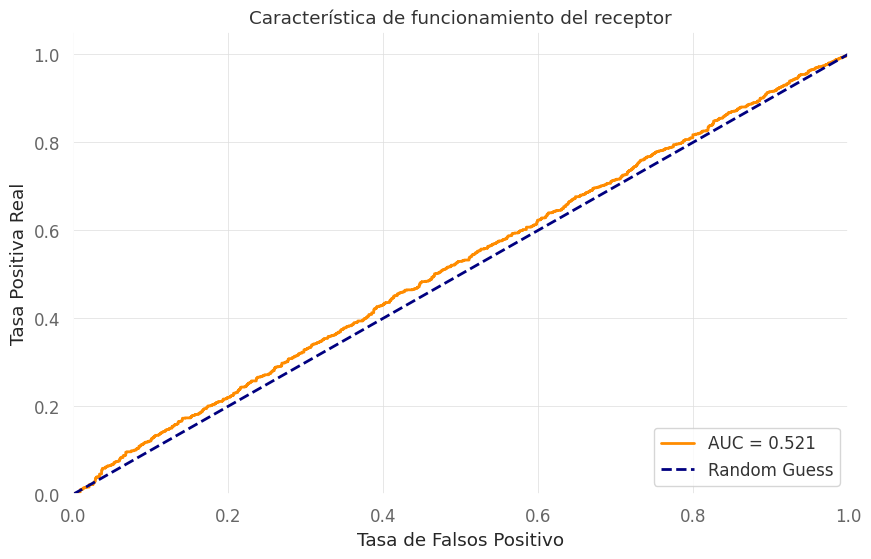

In [154]:
# Modelo CatBoostClassifier
model=CatBoostClassifier(random_state = 42,verbose=False)

# Entrenando y corriendo predicciones sobre el conjunto test
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_pred)
print(f'\n Score del Modelo AUC = {auc_score:.3f} \n')

# Curva AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivo')
plt.ylabel('Tasa Positiva Real')
plt.title('Característica de funcionamiento del receptor')
plt.legend(loc="lower right")
plt.style.use('ggplot')
plt.grid(True)
plt.show()


Al analizar los resultados anteriores, podemos concluir que nuestro modelo supera ligeramente una estimación aleatoria sobre si las acciones de Apple serán alcistas o bajistas al día siguiente.

En la mayoría de las tareas de aprendizaje automático, un modelo con una puntuación AUC de 0,521 podría no ser aprobado para su puesta en producción. Sin embargo, en medio del caos de los mercados financieros, anticiparse ligeramente a la predicción aleatoria de la dirección de las acciones puede resultar extremadamente rentable a largo plazo.

Echemos un vistazo al gráfico de importancia de las características a continuación para comprender cuáles de nuestras características fueron las más relevantes para las predicciones del modelo.

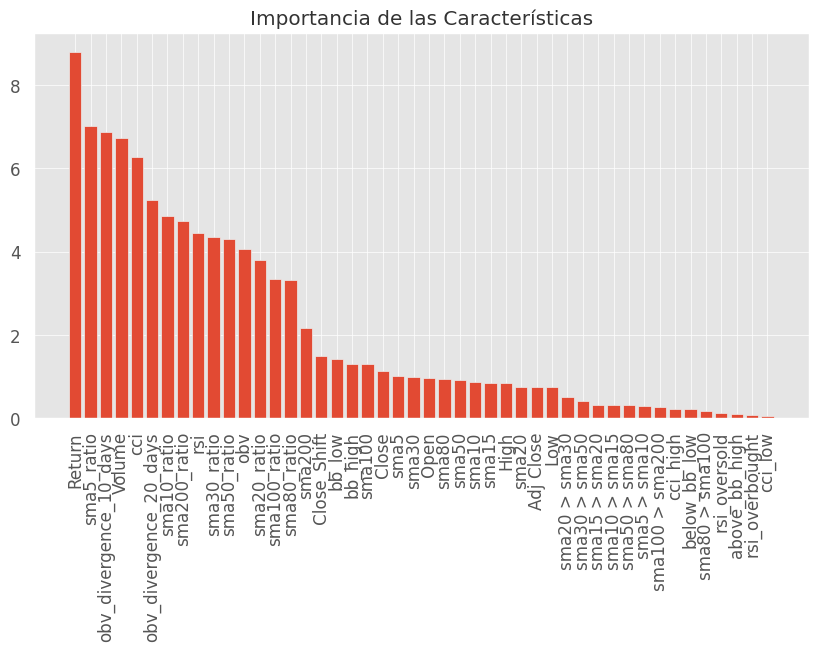

In [156]:
# Importancia de las Características
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.grid(True)
plt.title("Importancia de las Características")
plt.show()

In [128]:
y_pred # Veamos las probabilidades

array([0.34677799, 0.39700051, 0.47936523, ..., 0.29155696, 0.52321693,
       0.49477636])

Vomos a dividir los valores del array y_pred en clases diferentes según sus rangos percentiles.

Después de esto, crearemos una tabla que mostrará la frecuencia de las etiquetas verdaderas para cada grupo de percentiles de los valores en y_pred. Con esta información, podemos encontrar los diferentes rangos de probabilidades que fueron mayormente predictivos para los días alcistas y bajistas en el conjunto de entrenamiento, y trabajar con estos rangos específicos para desarrollar una estrategia de trading.

In [139]:
quantile_intervals = np.arange(0, 1, 0.099) # Intervalos para Cuantiles
quantile_values = np.quantile(y_pred, quantile_intervals) # y_pred en 8 cuantiles
# Agregamos duplicates='drop' para manejar bin edges duplicados
classes = pd.cut(y_pred, quantile_values, duplicates='drop') # Agrupando porbabilidades de acuerdo s los cuantiles
X_test['y_true'] = y_test # Creando nueva columna en X_test set la cúal contiene los valores Verdaderos
table = pd.crosstab(classes, X_test['y_true']) # Creación de una tabla que cuente las etiquetas verdaderas según cada rango de probabilidad
table

y_true,0,1
row_0,,
"(0.063, 0.279]",120,118
"(0.279, 0.312]",110,128
"(0.312, 0.342]",113,125
"(0.342, 0.365]",112,126
"(0.365, 0.394]",120,118
"(0.394, 0.427]",111,128
"(0.427, 0.468]",108,130
"(0.468, 0.51]",106,132
"(0.51, 0.558]",113,125


Según la información de la tabla anterior, parece que las predicciones en el rango de $(0.063, 0.279]$ resultaron en 120 días bajistas, en comparación con 118 días alcistas para las acciones de Apple. Esto sugiere que estos valores de probabilidad en particular fueron acertados al predecir días bajistas.

Con esto en mente, podemos desarrollar una estrategia de trading que consiste en vender en corto acciones de Apple siempre que nuestro modelo genere un valor de probabilidad dentro de los rangos con mayor frecuencia de días bajistas. De igual manera, compramos acciones de Apple siempre que nuestro modelo genere un valor de probabilidad dentro de los rangos con mayor frecuencia de días alcistas.



In [140]:
sign = np.zeros_like(y_pred) # Array de ceros de la misma dim que y_pred

# Señal de Venta en corto
sign[((y_pred >= 0.063) & (y_pred < 0.279)) | ((y_pred > 0.365) & (y_pred < 0.394))] = -1

# Señal de compra
sign[((y_pred >= 0.279) & (y_pred <= 0.365)) |
            ((y_pred >= 0.394) & (y_pred <= 0.658))] = 1

# Desplegado de señales
sign

array([1., 1., 1., ..., 1., 1., 1.])

Ahora creamos una nueva columna de signo en el conjunto X_test, que almacenará los valores de la matriz anterior.

In [141]:
X_test['sign'] = sign #Nueva Columna

In [142]:
X_test.head(15)

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200,y_true,sign
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-16,24.981848,27.760000,28.000000,27.632500,27.945000,156930400,25.166328,-0.733046,25.040342,24.995120,...,1,1,0,0,0,0,0,0,1,1.0
2015-10-19,25.137083,27.932501,27.937500,27.527500,27.700001,119036800,24.981848,0.621392,25.046191,25.016493,...,1,1,0,0,1,0,0,0,1,1.0
2015-10-20,25.596045,28.442499,28.542500,27.705000,27.834999,195871200,25.137083,1.825834,25.135283,25.071839,...,1,1,0,0,1,0,0,0,0,1.0
2015-10-21,25.593796,28.440001,28.895000,28.424999,28.500000,167180800,25.596045,-0.008786,25.295020,25.138883,...,1,1,0,0,1,0,0,0,1,1.0
2015-10-22,25.985256,28.875000,28.875000,28.525000,28.582500,166616400,25.593796,1.529513,25.458805,25.273871,...,1,1,1,0,1,0,0,0,1,1.0
2015-10-23,26.790693,29.770000,29.807501,29.082500,29.174999,237467600,25.985256,3.099593,25.820575,25.430458,...,1,1,1,0,1,0,0,0,0,1.0
2015-10-26,25.935770,28.820000,29.532499,28.730000,29.520000,265335200,26.790693,-3.191120,25.980312,25.513251,...,1,1,1,0,1,0,0,0,0,1.0
2015-10-27,25.771528,28.637501,29.135000,28.497499,28.850000,279537600,25.935770,-0.633264,26.015409,25.575346,...,1,1,1,0,1,0,0,0,1,1.0
2015-10-28,26.833433,29.817499,29.825001,29.014999,29.232500,342205600,25.771528,4.120458,26.263336,25.779178,...,1,1,1,0,1,0,0,0,1,1.0


Entonces, cuando sign = 1, compramos la acción esperando un rendimiento positivo al día siguiente. De igual forma, cuando sign = -1, vendemos las acciones en corto, esperando un rendimiento negativo para Apple al día siguiente.

En la siguiente línea de código, crearemos una variable de posición que describirá qué posición mantendremos cada día específico según el signo que el modelo nos proporcionó el día anterior, es decir, comprar o vender.

Después, crearemos una columna llamada model_returns que simplemente multiplicará la posición actual por el rendimiento diario de las acciones de Apple. Esto indicará si nuestra posición generó ganancias o pérdidas según si el día fue alcista o bajista.

In [143]:
X_test['position'] = X_test['sign'].shift(1) # Atributo 'position'
X_test['model_returns'] = X_test['position'] * X_test['Return'] # Creamos 'daily returns'para la estrategia

In [144]:
#Checando X_test
X_test.head(10)

Price,Adj Close,Close,High,Low,Open,Volume,Close_Shift,Return,sma5,sma10,...,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200,y_true,sign,position,model_returns
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-16,24.981848,27.760000,28.000000,27.632500,27.945000,156930400,25.166328,-0.733046,25.040342,24.995120,...,0,0,0,0,0,0,1,1.0,NaN,NaN
2015-10-19,25.137083,27.932501,27.937500,27.527500,27.700001,119036800,24.981848,0.621392,25.046191,25.016493,...,0,0,1,0,0,0,1,1.0,1.0,0.621392
2015-10-20,25.596045,28.442499,28.542500,27.705000,27.834999,195871200,25.137083,1.825834,25.135283,25.071839,...,0,0,1,0,0,0,0,1.0,1.0,1.825834
2015-10-21,25.593796,28.440001,28.895000,28.424999,28.500000,167180800,25.596045,-0.008786,25.295020,25.138883,...,0,0,1,0,0,0,1,1.0,1.0,-0.008786
2015-10-22,25.985256,28.875000,28.875000,28.525000,28.582500,166616400,25.593796,1.529513,25.458805,25.273871,...,1,0,1,0,0,0,1,1.0,1.0,1.529513
2015-10-23,26.790693,29.770000,29.807501,29.082500,29.174999,237467600,25.985256,3.099593,25.820575,25.430458,...,1,0,1,0,0,0,0,1.0,1.0,3.099593
2015-10-26,25.935770,28.820000,29.532499,28.730000,29.520000,265335200,26.790693,-3.191120,25.980312,25.513251,...,1,0,1,0,0,0,0,1.0,1.0,-3.191120
2015-10-27,25.771528,28.637501,29.135000,28.497499,28.850000,279537600,25.935770,-0.633264,26.015409,25.575346,...,1,0,1,0,0,0,1,1.0,1.0,-0.633264
2015-10-28,26.833433,29.817499,29.825001,29.014999,29.232500,342205600,25.771528,4.120458,26.263336,25.779178,...,1,0,1,0,0,0,1,1.0,1.0,4.120458


Al calcular la rentabilidad diaria de la estrategia, podemos analizar la última década y obtener la rentabilidad acumulada de las acciones de Apple en general y la rentabilidad acumulada de nuestra estrategia. Podemos, entonces, comparar una estrategia simple de compra y retención con nuestro modelo y determinar cuál nos ofrecería la mayor rentabilidad en los últimos años.

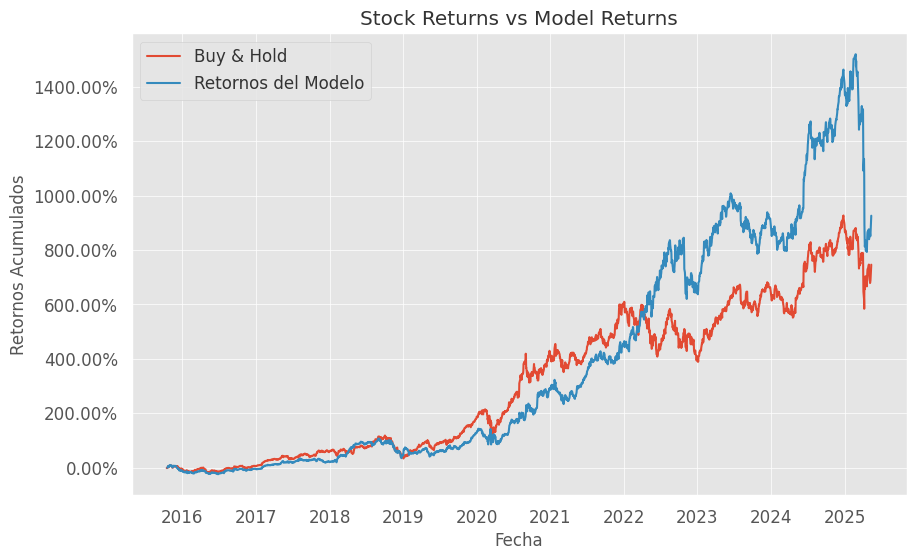


 Retornos Acumulados Buy & Hold = 746.09% 
 Retornos Acumulados Modelo = 925.90%


In [158]:
# Cálculo de la rentabilidad acumulada de las acciones de Apple
buy_and_hold_total_returns = (1 + X_test['Return'] / 100).cumprod()
buy_and_hold_total_returns = (buy_and_hold_total_returns - 1) * 100

# Calcular los rendimientos acumulados del modelo
model_cumulative_returns = (1 + X_test['model_returns'] / 100).cumprod()
model_cumulative_returns = (model_cumulative_returns - 1) * 100

# Trazado de un gráfico de líneas que compara las estrategias "Buy & Hold" y Model
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(buy_and_hold_total_returns, label = 'Buy & Hold')
ax.plot(model_cumulative_returns, label = 'Retornos del Modelo')
ax.legend()
ax.set_xlabel('Fecha')
ax.set_ylabel('Retornos Acumulados')
ax.set_title('Stock Returns vs Model Returns')

# Añadismo signo '%' a las marcas del eje y
def percent_formatter(x, pos):
    return f'{x:.2f}%'

# Importar matplotlib.ticker para usar FuncFormatter
import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))

plt.style.use('ggplot')
plt.grid(True)
plt.show()
#plt.title('Stock Returns vs Model Returns')
# Imprimiendo
print(f'\n Retornos Acumulados Buy & Hold = {buy_and_hold_total_returns.iloc[-1]:.2f}% \n Retornos Acumulados Modelo = {model_cumulative_returns.iloc[-1]:.2f}%')

El gráfico de líneas anterior muestra una comparación del rendimiento de una estrategia simple de compra y retención frente a una estrategia basada en las predicciones generadas por nuestro modelo.

Es evidente que, con el tiempo, la estrategia basada en el modelo superó al enfoque de compra y retención. Sin embargo, hubo algunos periodos en los que el enfoque de compra y retención tuvo un mejor rendimiento que el modelo.

El rendimiento general de la estrategia resultó en una impresionante rentabilidad acumulada del 925.90 %, en comparación con el 746.09 % obtenido con el enfoque de compra y retención. Sin embargo, es fundamental tener en cuenta que estas cifras no incluyen gastos como comisiones, impuestos y otros costes asociados a la implementación de la estrategia.



El modelo que hemos creado anteriormente es solo un enfoque inicial, y aún quedan muchas mejoras potenciales por realizar. El uso de bibliotecas para ajustar hiperparámetros podría proporcionarnos un modelo de mayor rendimiento, así como una selección de características para usar solo las más relevantes como predictores.

Al modelar para el mercado de valores, también es importante experimentar con mucho más que solo indicadores técnicos.
En general, te recomiendo encarecidamente que pruebes a entrenar tu propio modelo con las características que te gustaría añadir. ¡No dudes en ser creativo!

Recuerda que no existe un enfoque único para el aprendizaje automático y los mercados financieros. Si bien este modelo funcionó bien con las acciones de Apple, puede funcionar de forma deficiente con NVDA , MSFT y otros mercados.